In [1]:
import argparse
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from skimage.exposure import match_histograms
from scipy.spatial.distance import cosine, minkowski
from skimage.filters.rank import modal

thispath = Path().resolve()
base_path = thispath.parent
sys.path.insert(0, str(base_path))
from utils import plots
from utils.metrics import dice_score, rel_abs_vol_dif, avd, haussdorf, mutual_information
from models.simple_predictors import (
    brain_tissue_segmentation_tm, brain_tissue_segmentation_prob_map, brain_tissue_segmentation_tm_prob_map
)
from utils.utils import save_img_from_array_using_referece

## Define all necessary paths

In [2]:
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'
mni_atlas_path = data_path / 'mni_atlas'
experiments_path = base_path / 'experiments/simple_segmenters'

# Predict using only tissue models (intensity info)

In [19]:
# Load the reference image that will be used to match the histograms to
ibsr18_path = train_set_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ibsr18_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)
ref_shape = ref_img_array.shape

# Define the output path
n_experiments_path = experiments_path/'tissue_models_ibsr18/segmentations/'
n_experiments_path.mkdir(exist_ok=True, parents=True)

# Load the tissue models
with open(data_path / 'tissue_models/tissue_models_3C.pkl', 'rb') as tm_file:
    tissue_models = pickle.load(tm_file)

# Process train cases
for case_path in train_set_path.iterdir():
    case = case_path.name

    # Load the image
    img_path = case_path / f'{case}_n4.nii.gz'
    img = sitk.ReadImage(str(img_path), sitk.sitkUInt8)
    img_array = sitk.GetArrayFromImage(img)
    
    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Match histograms
    img_array[img_array!=0] = match_histograms(img_array[img_array!=0], ref_img_array[ref_img_array!=0])

    # Segment with the tissue models
    segm = brain_tissue_segmentation_tm(img_array, brain_mask_array, tissue_models)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_models_ibsr18/segmentations/{case}.nii.gz')

# Process validation cases
for case_path in val_set_path.iterdir():
    case = case_path.name

    # Load the image
    img_path = case_path / f'{case}_n4.nii.gz'
    img = sitk.ReadImage(str(img_path), sitk.sitkUInt8)
    img_array = sitk.GetArrayFromImage(img)

    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Match histograms
    img_array[img_array!=0] = match_histograms(img_array[img_array!=0], ref_img_array[ref_img_array!=0])

    # Segment with the tissue models
    segm = brain_tissue_segmentation_tm(img_array, brain_mask_array, tissue_models)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_models_ibsr18/segmentations/{case}.nii.gz')

# Predict using only probability maps (spatial info)

In [23]:
# Load the reference image that will be used to match the histograms to
ibsr18_path = train_set_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ibsr18_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)
ref_shape = ref_img_array.shape

# Define the output path
n_experiments_path = experiments_path/'tissue_prob_maps_ibsr18/segmentations/'
n_experiments_path.mkdir(exist_ok=True, parents=True)

# Process train cases
for case_path in train_set_path.iterdir():    
    case = case_path.name

    # Load the probabilistic atlas to use
    atlas_path = train_set_path / case /f'{case}_atlas.nii.gz'
    atlas_img = sitk.ReadImage(str(atlas_path))
    atlas_img_array = sitk.GetArrayFromImage(atlas_img)

    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Segment with the tissue models
    segm = brain_tissue_segmentation_prob_map(brain_mask_array, atlas_img_array)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_prob_maps_ibsr18/segmentations/{case}.nii.gz')

# Process validation cases
for case_path in val_set_path.iterdir():
    case = case_path.name
    
    # Load the probabilistic atlas to use
    atlas_path = val_set_path / case /f'{case}_atlas.nii.gz'
    atlas_img = sitk.ReadImage(str(atlas_path))
    atlas_img_array = sitk.GetArrayFromImage(atlas_img)

    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Segment with the tissue models
    segm = brain_tissue_segmentation_prob_map(brain_mask_array, atlas_img_array)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_prob_maps_ibsr18/segmentations/{case}.nii.gz')

# Predict using both tissue maps and probability maps (spatial info)

In [ ]:
# Load the reference image that will be used to match the histograms to
ibsr18_path = train_set_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ibsr18_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)
ref_shape = ref_img_array.shape

# Define the output path
n_experiments_path = experiments_path/'tissue_models_tissue_prob_maps_ibsr18/segmentations/'
n_experiments_path.mkdir(exist_ok=True, parents=True)

# Load the tissue models
with open(data_path / 'tissue_models/tissue_models_3C.pkl', 'rb') as tm_file:
    tissue_models = pickle.load(tm_file)

# Process train cases
for case_path in train_set_path.iterdir():
    case = case_path.name

    # Load the probabilistic atlas to use
    atlas_path = train_set_path / case /f'{case}_atlas.nii.gz'
    atlas_img = sitk.ReadImage(str(atlas_path))
    atlas_img_array = sitk.GetArrayFromImage(atlas_img)

    # Load the image
    img_path = case_path / f'{case}_n4.nii.gz'
    img = sitk.ReadImage(str(img_path), sitk.sitkUInt8)
    img_array = sitk.GetArrayFromImage(img)

    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Match histograms
    img_array[img_array!=0] = match_histograms(img_array[img_array!=0], ref_img_array[ref_img_array!=0])

    # Segment with the tissue models
    segm = brain_tissue_segmentation_tm_prob_map(
        img_array, brain_mask_array, tissue_models, atlas_img_array)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_models_tissue_prob_maps_ibsr18/segmentations/{case}.nii.gz')

# Process validation cases
for case_path in val_set_path.iterdir():
    case = case_path.name

    # Load the probabilistic atlas to use
    atlas_path = val_set_path / case /f'{case}_atlas.nii.gz'
    atlas_img = sitk.ReadImage(str(atlas_path))
    atlas_img_array = sitk.GetArrayFromImage(atlas_img)

    # Load the image
    img_path = case_path / f'{case}_n4.nii.gz'
    img = sitk.ReadImage(str(img_path), sitk.sitkUInt8)
    img_array = sitk.GetArrayFromImage(img)

    # Load its brain mask
    brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.ReadImage(str(brain_mask_path))
    brain_mask_array = sitk.GetArrayFromImage(brain_mask)

    # Match histograms
    img_array[img_array!=0] = match_histograms(img_array[img_array!=0], ref_img_array[ref_img_array!=0])

    # Segment with the tissue models
    segm = brain_tissue_segmentation_tm_prob_map(
        img_array, brain_mask_array, tissue_models, atlas_img_array)
    save_img_from_array_using_referece(
        segm, img, experiments_path/f'tissue_models_tissue_prob_maps_ibsr18/segmentations/{case}.nii.gz')
    

# Predict using multi-atlas

Compute the distances between the atlases and targets

In [7]:
# Define the output path
output_path = base_path / 'experiments/elastix'
output_pm_path = output_path / 'Par0010bspline/ava_preproc'

# Define the placeholders for the distances
mi_df = []
euclidean_df = []
cos_df = []
mse_df = []
idxs = []

# For each image in the train+validation dataset:
for ref in tqdm(output_pm_path.iterdir(), total=len(list(output_pm_path.iterdir()))):
    # Store the name of the case been processed
    ref_img_name = ref.name
    idxs.append(ref_img_name)

    # Define the placeholder for the metrics of that case
    mi_row = []
    euclidean_row = []
    cos_row = []
    mse_row = []
    cols = []

    # Load the reference image
    ref_img = sitk.GetArrayFromImage(sitk.ReadImage(str(ref/ref_img_name/f'{ref_img_name}_n4.nii.gz')))

    # For each image in the train+validation dataset get the distance with the reference one
    for mov_img_path in ref.iterdir():

        # Load each of the "atlas" images
        mov_case = mov_img_path.name
        mov_img = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_img_path/f'{mov_case}_n4.nii.gz')))

        # Get the distances between atlas and target and store them
        mi = mutual_information(ref_img, mov_img) if (mov_case!=ref.name) else 1
        mi_row.append(mi)
        mse = np.square(np.subtract(ref_img, mov_img)).mean() if (mov_case!=ref.name) else 1
        mse_row.append(mse)
        euclidean = minkowski(ref_img.flatten(), mov_img.flatten(), p=2)  if (mov_case!=ref.name) else 1
        euclidean_row.append(euclidean)
        cos = cosine(ref_img.flatten(), mov_img.flatten())  if (mov_case!=ref.name) else 1
        cos_row.append(cos)
        cols.append(mov_case)

    # Adjust the distances and normalize them to sum one
    a = np.array(mi_row)
    a = np.where(a != 1, 1, 0) * a
    mi_row = a/np.sum(a).tolist()
    mi_df.append(mi_row)

    a = 1/np.array(euclidean_row)
    a = np.where(a != 1, 1, 0) * a
    euclidean_row = (a/np.sum(a)).tolist()
    euclidean_df.append(euclidean_row)
    
    a = 1/np.array(mse_row)
    a = np.where(a != 1, 1, 0) * a
    mse_row = (a/np.sum(a)).tolist()
    mse_df.append(mse_row)
    
    a = 1/np.array(cos_row)
    a = np.where(a != 1, 1, 0) * a
    cos_row = (a/np.sum(a)).tolist()
    cos_df.append(cos_row)

# Save the distances csv
distances_path = base_path / 'experiments/elastix/Par0010bspline/ava_preproc/'
mi_df = pd.DataFrame(mi_df, index=idxs, columns=cols)
mi_df.to_csv(distances_path.parent/'mi.csv')
euclidean_df = pd.DataFrame(euclidean_df, index=idxs, columns=cols)
euclidean_df.to_csv(distances_path.parent/'euclidean.csv')
mse_df = pd.DataFrame(mse_df, index=idxs, columns=cols)
mse_df.to_csv(distances_path.parent/'mse.csv')
cos_df = pd.DataFrame(cos_df, index=idxs, columns=cols)
cos_df.to_csv(distances_path.parent/'cosine.csv')

100%|██████████| 15/15 [02:01<00:00,  8.10s/it]


### Plot the distances matrices (the rows must sum to one)

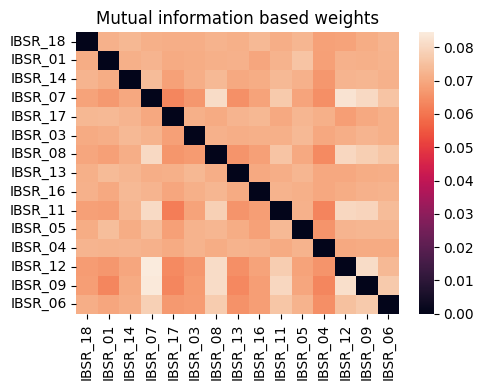

In [14]:
# plt.figure(figsize=(10,8))
# plt.subplot(2,2,1)
# plt.title('mse')
# sns.heatmap(mse_df)
# plt.subplot(2,2,2)
# plt.title('euclidean')
# sns.heatmap(euclidean_df)
# plt.subplot(2,2,3)
# plt.title('cosine')
# sns.heatmap(cos_df)
# plt.subplot(2,2,4)
# plt.title('mi')
# sns.heatmap(mi_df)
# plt.tight_layout()
# plt.show()

savepath = base_path / 'experiments/simple_segmenters'

plt.figure(figsize=(5,4))
plt.title('Mutual information based weights')
sns.heatmap(mi_df)
plt.tight_layout()
plt.savefig(savepath/'mutual_info_weights.svg', bbox_inches='tight', format='svg')

## Use the distances between the atlases and the targets as weights for the multiatlas segementation

In [9]:
# Define the necessary paths
output_path = base_path / 'experiments/elastix'
output_pm_path = output_path / 'Par0010bspline/ava_preproc'
distances_path = base_path / 'experiments/elastix/Par0010bspline/'

# Load the distances
mi_df = pd.read_csv(distances_path/'mi.csv', index_col=0)
euclidean_df = pd.read_csv(distances_path/'euclidean.csv', index_col=0)
mse_df = pd.read_csv(distances_path/'mse.csv', index_col=0)
cos_df = pd.read_csv(distances_path/'cosine.csv', index_col=0)

idxs = []

# For each target
for ref in tqdm(output_pm_path.iterdir(), total = len(list(output_pm_path.iterdir()))):

    # Define the target name
    ref_img_name = ref.name
    idxs.append(ref_img_name)

    # Load the target image
    ref_img = sitk.ReadImage(str(ref/ref_img_name/f'{ref_img_name}_n4.nii.gz'))
    ref_img_array = sitk.GetArrayFromImage(ref_img)
    ref_shape = ref_img_array.shape

    # Define the placeholders for the weighted probabilistic atlas
    n_classes = 4
    n_volumes = 14
    atlas_prob_mse = np.zeros((n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    atlas_prob_euclidean = np.zeros((n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    atlas_prob_cosine = np.zeros((n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    atlas_prob_mi = np.zeros((n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    atlas_prob_equal = np.zeros((n_classes, ref_shape[0], ref_shape[1], ref_shape[2])).astype('float32')
    
    cols = []

    # For each atlas image load it and weight it with the corresponding weight
    for mov_img_path in ref.iterdir():

        # Avoid including the image itsef as an atlas
        mov_case = mov_img_path.name
        if mov_case == ref_img_name:
            continue

        # Load the atlas image
        atlas_img = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_img_path/f'r_{mov_case}_seg.nii.gz')))

        # For each class, generate the probabilistic atlas weighting the atlases acording to the distances to the target
        for c in range(n_classes):
            atlas_prob_mse[c, :, :, :] += np.where(atlas_img == c, 1, 0) * mse_df.at[ref_img_name, mov_case]
            atlas_prob_euclidean[c, :, :, :] += np.where(atlas_img == c, 1, 0) * euclidean_df.at[ref_img_name, mov_case]
            atlas_prob_cosine[c, :, :, :] += np.where(atlas_img == c, 1, 0) * cos_df.at[ref_img_name, mov_case]
            atlas_prob_mi[c, :, :, :] += np.where(atlas_img == c, 1, 0) * mi_df.at[ref_img_name, mov_case]
            atlas_prob_equal[c, :, :, :] += np.where(atlas_img == c, 1, 0) * (1/n_volumes)

    # Define the output path
    output_path = base_path / f'experiments/simple_segmenters_atlases/{ref_img_name}/'
    output_path.mkdir(exist_ok=True, parents=True)

    # Save the results
    save_img_from_array_using_referece(atlas_prob_mse, ref_img, output_path / 'prob_atlas_mse.nii.gz', True)
    save_img_from_array_using_referece(atlas_prob_euclidean, ref_img, output_path / 'prob_atlas_euclidean.nii.gz', True)
    save_img_from_array_using_referece(atlas_prob_cosine, ref_img, output_path / 'prob_atlas_cosine.nii.gz', True)
    save_img_from_array_using_referece(atlas_prob_mi, ref_img, output_path / 'prob_atlas_mi.nii.gz', True)
    save_img_from_array_using_referece(atlas_prob_equal, ref_img, output_path / 'prob_atlas_equal.nii.gz', True)

100%|██████████| 15/15 [04:29<00:00, 18.00s/it]


# Predict using only probability maps from multiatlas (spatial info)

In [10]:
# Define the probabilistic atlases path
atlases_path = base_path / 'experiments/simple_segmenters_atlases'

# For each of the different distances between the atlases and the target image
for weight in ['mi','cosine','equal', 'euclidean','mse']:

    # Define the output path
    n_experiments_path = experiments_path/f'multi_atlas_{weight}/segmentations/'
    n_experiments_path.mkdir(exist_ok=True, parents=True)

    # Process train cases
    for case_path in train_set_path.iterdir():
        case = case_path.name

        # Load the probabilistic atlas to use
        atlas_path = atlases_path / case /f'prob_atlas_{weight}.nii.gz'
        atlas_img = sitk.ReadImage(str(atlas_path))
        atlas_img_array = sitk.GetArrayFromImage(atlas_img)

        # Load its brain mask
        brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
        brain_mask = sitk.ReadImage(str(brain_mask_path))
        brain_mask_array = sitk.GetArrayFromImage(brain_mask)

        # Segment with the tissue models
        segm = brain_tissue_segmentation_prob_map(brain_mask_array, atlas_img_array)
        save_img_from_array_using_referece(
            segm, brain_mask, experiments_path/f'multi_atlas_{weight}/segmentations/{case}.nii.gz')

    # Process validation cases
    for case_path in val_set_path.iterdir():
        case = case_path.name

        # Load the probabilistic atlas to use
        atlas_path = atlases_path / case /f'prob_atlas_{weight}.nii.gz'
        atlas_img = sitk.ReadImage(str(atlas_path))
        atlas_img_array = sitk.GetArrayFromImage(atlas_img)

        # Load its brain mask
        brain_mask_path = case_path / f'{case}_brain_mask.nii.gz'
        brain_mask = sitk.ReadImage(str(brain_mask_path))
        brain_mask_array = sitk.GetArrayFromImage(brain_mask)

        # Segment with the tissue models
        segm = brain_tissue_segmentation_prob_map(brain_mask_array, atlas_img_array)
        save_img_from_array_using_referece(
            segm, brain_mask, experiments_path/f'multi_atlas_{weight}/segmentations/{case}.nii.gz')

# Predict using only probability maps from multiatlas STAPLE (spatial info)

In [92]:
# Define the path were the registered images are stored
output_path = base_path / 'experiments/elastix'
output_pm_path = output_path / 'Par0010bspline/ava_preproc'

# Define the output paths
label_names = {0: 'background', 1:'csf', 2:'gm', 3:'wm'}
experiments_path = base_path / 'experiments/simple_segmenters'
result_path = experiments_path / f'multi_atlas_staple/segmentations'
result_path.mkdir(exist_ok=True, parents=True)

# For each label (STAPLE only works with binary images)
for label in [1,2,3]:

    # For each the target image in the train + validation set
    for ref in tqdm(output_pm_path.iterdir(), total = len(list(output_pm_path.iterdir()))):

        # Load the target image
        ref_img_name = ref.name
        ref_img = sitk.ReadImage(str(ref/ref_img_name/f'{ref_img_name}_n4.nii.gz'))

        # Load the atlases registered to that target
        atlases_segms = []
        for mov_img_path in ref.iterdir():
            
            # Avoid including the target among the atlases
            mov_case = mov_img_path.name
            if mov_case == ref_img_name:
                continue
            
            # Load the atlas and stack it with the others
            atlas_labels = sitk.ReadImage(str(mov_img_path/f'r_{mov_case}_seg.nii.gz'), sitk.sitkInt16)
            atlas_labels_array = sitk.GetArrayFromImage(atlas_labels)
            atlas_labels_array = np.where(atlas_labels_array == label, 1, 0).astype('int16')
            atlas_labels = sitk.GetImageFromArray(atlas_labels_array)
            atlases_segms.append(atlas_labels)

        # Run the staple merging of othe atlases
        STAPLE_seg_sitk = sitk.STAPLE(atlases_segms, 1.0)
        STAPLE_seg_sitk = sitk.GetArrayFromImage(STAPLE_seg_sitk)
        
        # Store the result
        result_path = experiments_path/f'multi_atlas_staple/segmentations/{ref_img_name}_{label_names[label]}.nii.gz'
        save_img_from_array_using_referece(STAPLE_seg_sitk, ref_img, result_path)

100%|██████████| 15/15 [04:39<00:00, 18.63s/it]


Merge the different tissues in a single_file

In [108]:
# Define which are validation cases to be able to load the original masks
val_cases = ['IBSR_14', 'IBSR_17', 'IBSR_13', 'IBSR_11', 'IBSR_12']

# Define output path
result_path = experiments_path / f'multi_atlas_staple/segmentations'

# For each case in the train+val set
cases = list(set([a.name[:7] for a in list(result_path.iterdir())]))
for case in cases:

    # Load the brain mask
    partition = 'train_set' if case not in val_cases else 'validation_set'
    brain_mask_path = data_path / partition / case / f'{case}_brain_mask.nii.gz'
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(brain_mask_path), sitk.sitkUInt8))

    # Read the staple-merged segementation for each tissue class
    csf_path = result_path / f'{case}_csf.nii.gz'
    csf_img = sitk.ReadImage(str(csf_path), sitk.sitkUInt8)
    csf_img_array = sitk.GetArrayFromImage(csf_img)
    gm_path = result_path / f'{case}_gm.nii.gz'
    gm_img = sitk.GetArrayFromImage(sitk.ReadImage(str(gm_path), sitk.sitkUInt8))
    wm_path = result_path / f'{case}_wm.nii.gz'
    wm_img = sitk.GetArrayFromImage(sitk.ReadImage(str(wm_path), sitk.sitkUInt8))

    # Merge them all
    full_img = np.zeros_like(wm_img)
    full_img[gm_img == 1] = 2
    full_img[csf_img_array == 1] = 1
    full_img[wm_img == 1] = 3

    # Perform some whole filling with a modal filter
    full_img = modal(full_img, np.ones((3,3,3)), mask=brain_mask)
    
    # Store the results
    save_img_from_array_using_referece(full_img, csf_img, result_path/f'{case}.nii.gz')